____
__Universidad de San Andrés__<br/>
__Machine Learning__<br/>
__Modelado probabilistico de audios de ballenas y estudio de transfer learning__<br/>
__Martin Bianchi y Federico Gutman__
____

### Importamos las librerías necesarias

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from IPython.display import Audio, display
from sklearn.decomposition import PCA

### NOTAS
- ver repo para preprocesar espectrogrma
    - ver de reducir el y-lim del spectrograma -> averiguar bien entre que frecuencias se mueven los cantos de ballena
- cambiar noise a no right whale
- cambiar el idioma a español


### Definimos algunas variables globales

In [2]:
SEED = 3            # semilla para reproductibilidad
SR = 2000           # sampling rate
N_FFT = 256         # tamaño de la ventana
HOP_LENGTH = 64     # salto entre frames
N_MELS = 50         # frequency bins (resolución)
MAX_FREQ = 600      # máxima frecuencia para los espectrogramas --ponerlo en 500--

### Cargamos los datos y los visualizamos

In [3]:
def load_data(train_path:str, test_path:str, labels_path:str, sampling_rate=SR):
    test_files = [f for f in os.listdir(test_path) if f.endswith('.aiff')]
    labels_df = pd.read_csv(labels_path)

    audio_df = labels_df.copy()
    audio_df['filepath'] = audio_df['clip_name'].apply(lambda x: os.path.join(train_path, x))
    audio_df['audio'] = audio_df['filepath'].apply(lambda path: librosa.load(path, sr=sampling_rate)[0])

    return audio_df, labels_df, test_files

def display_random_samples(dataset:pd.DataFrame, sampling_rate=SR):
    np.random.seed(SEED)

    # SAMPLES
    whale_sample = dataset[dataset['label'] == 1].sample(5)['audio']
    noise_sample = dataset[dataset['label'] == 0].sample(5)['audio']

    # AUDIO
    print('right whale call random audio sample')
    display(Audio(np.array(whale_sample.iloc[0]), rate=sampling_rate*1.5))
    print('\nno whale random audio sample')
    display(Audio(np.array(noise_sample.iloc[0]), rate=sampling_rate*1.5))

    # SOUND-WAVE
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))

    for i in range(5):
        axes[0, i].plot(np.array(whale_sample.iloc[i]))
        axes[0, i].set_title('Whale')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        axes[1, i].plot(np.array(noise_sample.iloc[i]), color='#FF6961')
        axes[1, i].set_title('No Whale')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

    plt.tight_layout()
    plt.show()

    # MULTIPLE SPECTROGRAMS
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(5):
        whale_sample_spectrogram = get_melspectrogram(whale_sample.iloc[i])
        img0 = librosa.display.specshow(whale_sample_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[0, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[0, i].set_title('Whale')
        axes[0, i].set_ylim([0, MAX_FREQ])
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        axes[0, i].set_xlabel('')
        axes[0, i].set_ylabel('')

        noise_sample_spectrogram = get_melspectrogram(noise_sample.iloc[i])
        img1 = librosa.display.specshow(noise_sample_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[1, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[1, i].set_title('No Whale')
        axes[1, i].set_ylim([0, MAX_FREQ])
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
        axes[1, i].set_xlabel('')
        axes[1, i].set_ylabel('')

    plt.tight_layout()
    plt.show()

    # TWO SPECTROGRAMS
    whale_sample2 = dataset[dataset['label'] == 1].sample(1, random_state=SEED+1)['audio']
    noise_sample2 = dataset[dataset['label'] == 0].sample(1, random_state=SEED+1)['audio']
    
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    whale_sample2_spectrogram = get_melspectrogram(whale_sample2.iloc[0])
    img0 = librosa.display.specshow(whale_sample2_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[0], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[0].set_title('Whale')
    axes[0].set_ylim([0, MAX_FREQ])
    fig.colorbar(img0, ax=axes[0], format="%+2.0f dB")

    noise_sample2_spectrogram = get_melspectrogram(noise_sample2.iloc[0])
    img1 = librosa.display.specshow(noise_sample2_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[1], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[1].set_title('No Whale')
    axes[1].set_ylim([0, MAX_FREQ])
    fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

def normalize(dataset:pd.DataFrame, column:str):
    dataset[column] = dataset[column].apply(lambda x: x / np.max(np.abs(x)))

def get_signal_energy(dataset:pd.DataFrame, column:str):
    energy = []
    df = dataset.copy()
    for x in df[column]:
        energy.append(np.sum(np.square(x)))
    df['energy'] = energy

    return df

def get_melspectrogram(sample:pd.DataFrame, sampling_rate=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_spectrogram = librosa.feature.melspectrogram(y=np.array(sample), sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=MAX_FREQ)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram

def get_all_mel_spectrograms(audio_df, sampling_rate=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_specs = []
    for audio in audio_df['audio']:
        mel = get_melspectrogram(audio, sampling_rate, n_fft, hop_length, n_mels)
        mel_specs.append(mel.flatten())
    return np.array(mel_specs)

def show_class_balance(dataset:pd.DataFrame):
    plt.figure(figsize=(5, 4))
    ax = sns.countplot(
        x='label',
        data=dataset,
        palette={0: '#FF6961', 1: plt.rcParams['axes.prop_cycle'].by_key()['color'][0]},
        hue='label',
        legend=False
    )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Noise', 'Whale'])
    ax.legend(['Noise', 'Whale'], title='Class')
    plt.show()

def extract_time_acoustic_features(dataset:pd.DataFrame):
    new_features = []
    for audio in dataset['audio']:
        audio_np = np.array(audio)
        acoustic_features = {
            'rms_energy': np.mean(librosa.feature.rms(y=audio_np)),
            'zcr': np.mean(librosa.feature.zero_crossing_rate(y=audio_np)),
        }
        new_features.append(acoustic_features)
    features_df = pd.DataFrame(new_features)
    return features_df

def extract_frequency_acoustic_features(dataset:pd.DataFrame):
    new_features = []
    for audio in dataset['audio']:
        audio_np = np.array(audio)
        acoustic_features = {
            'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=audio_np)),
            'spectral_bandwidth': np.mean(librosa.feature.spectral_bandwidth(y=audio_np)),
            'spectral_rolloff': np.mean(librosa.feature.spectral_rolloff(y=audio_np)),
            'spectral_flatness': np.mean(librosa.feature.spectral_flatness(y=audio_np))
        }
        new_features.append(acoustic_features)
    features_df = pd.DataFrame(new_features)
    return features_df

def extract_acoustic_features(dataset:pd.DataFrame):
    time_features = extract_time_acoustic_features(dataset)
    frequency_features = extract_frequency_acoustic_features(dataset)

    new_df = pd.concat([dataset.reset_index(drop=True), time_features], axis=1)
    new_df = pd.concat([new_df.reset_index(drop=True), frequency_features], axis=1)
    
    return new_df

def display_features_boxplots(audio_features_df:pd.DataFrame):
    time_features = ['rms_energy', 'zcr']
    freq_features = ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'spectral_flatness']

    # TIME
    fig, axes = plt.subplots(1, len(time_features), figsize=(5 * len(time_features), 5))
    if len(time_features) == 1:
        axes = [axes]
    for i, feature in enumerate(time_features):
        sns.boxplot(x='label', y=feature, data=audio_features_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{feature} by Class')
        axes[i].set_xlabel('Class')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Noise', 'Whale'])

    plt.suptitle('Time Domain Features by Class')
    plt.tight_layout()
    plt.show()

    # FREQUENCY
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    for i, feature in enumerate(freq_features):
        sns.boxplot(x='label', y=feature, data=audio_features_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{feature} by Class')
        axes[i].set_xlabel('Class')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Noise', 'Whale'])

    plt.suptitle('Frequency Domain Features by Class')
    plt.tight_layout()
    plt.show()

def plot_pca(dataset:pd.DataFrame, pca_arr):
    plt.figure(figsize=(8,6))
    scatter = sns.scatterplot(
        x=pca_arr[:,0], 
        y=pca_arr[:,1], 
        hue=dataset['label'], 
        palette={0: '#FF6961', 1: '#1f77b4'}
    )
    plt.title('PCA of Mel Spectrograms')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    # Fix legend labels and colors
    handles, _ = scatter.get_legend_handles_labels()
    scatter.legend(handles=handles, title='Class', labels=['Noise', 'Whale'])
    plt.show()

def plot_average_spectrograms(audio_df:pd.DataFrame):
    whale_spectrograms = []
    noise_spectrograms = []
    for audio, label in zip(audio_df['audio'], audio_df['label']):
        spectrogram = get_melspectrogram(audio)
        if label == 1:
            whale_spectrograms.append(spectrogram)
        else: 
            noise_spectrograms.append(spectrogram)
    
    whale_spectrograms = np.array(whale_spectrograms)
    noise_spectrograms = np.array(noise_spectrograms)

    whale_average_spectrogram = whale_spectrograms.mean(axis=0)
    noise_average_spectrogram = noise_spectrograms.mean(axis=0)
    average_differences_spectrogram = whale_average_spectrogram - noise_average_spectrogram

    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    img0 = librosa.display.specshow(whale_average_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[0], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[0].set_title('Whale Call Average Spectrogram', pad=20)
    axes[0].set_ylim([0, MAX_FREQ])
    # axes[0].set_xticks([])
    # axes[0].set_yticks([])
    fig.colorbar(img0, ax=axes[0], format="%+2.0f dB")

    img1 = librosa.display.specshow(noise_average_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[1], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[1].set_title('No Whale Call Average Spectrogram', pad=20)
    axes[1].set_ylim([0, MAX_FREQ])
    # axes[1].set_xticks([])
    # axes[1].set_yticks([])
    fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

    img2 = librosa.display.specshow(average_differences_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[2], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[2].set_title('Average Differences Spectrogram', pad=20)
    axes[2].set_ylim([0, MAX_FREQ])
    # axes[2].set_xticks([])
    # axes[2].set_yticks([])
    fig.colorbar(img2, ax=axes[2], format="%+2.0f dB")

    # 3 subplots -> average spectrogram whale, noise, resto y consigo diferencias
    plt.tight_layout()
    plt.show()


In [4]:
train_dir = 'data/whale-detection-challenge/data/train'
test_dir = 'data/whale-detection-challenge/data/test'
labels_dir = 'data/whale-detection-challenge/data/train.csv'

audio_df, labels_df, test_files = load_data(train_dir, test_dir, labels_dir)

right whale call random audio sample



no whale random audio sample


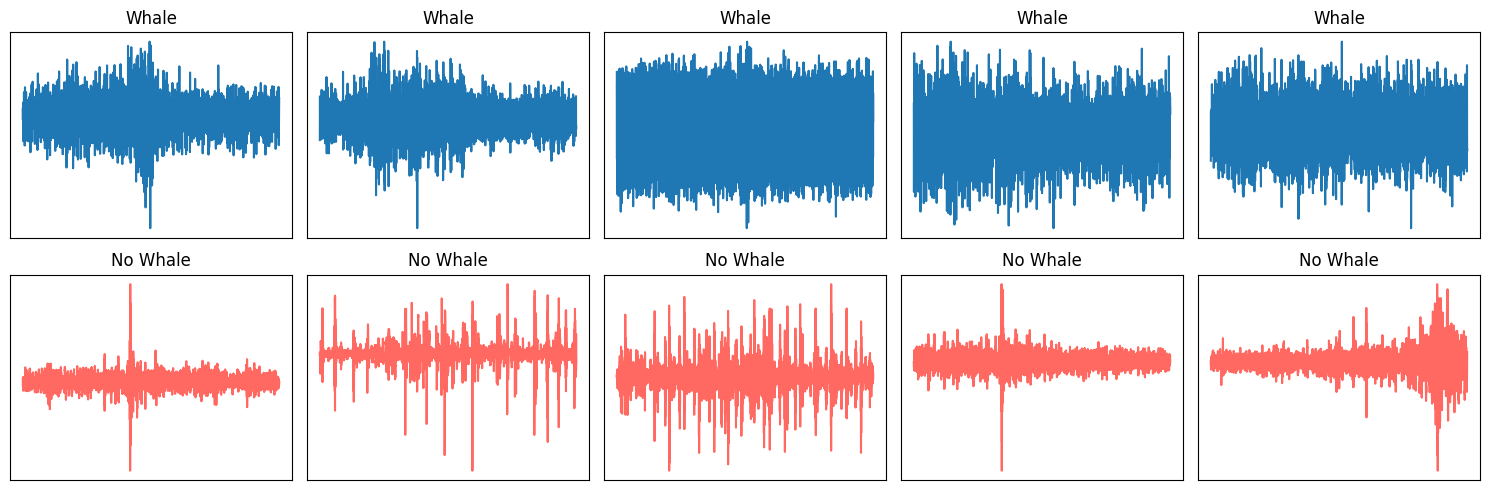

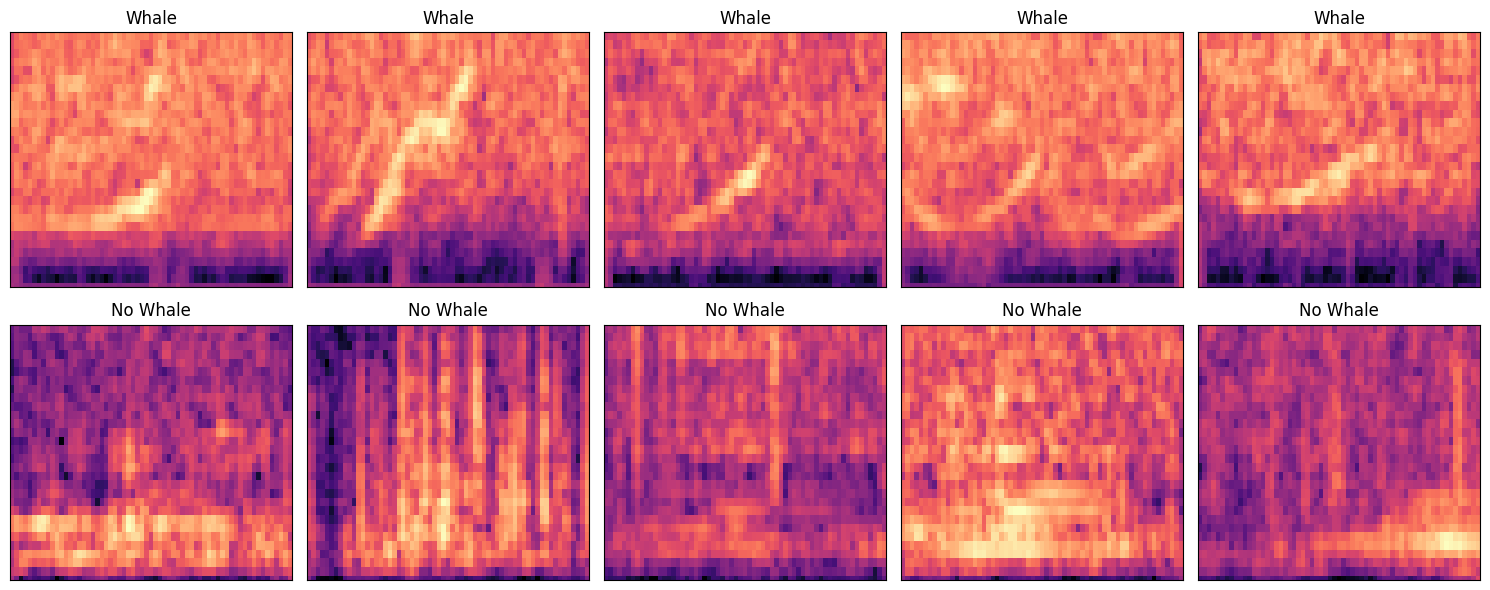

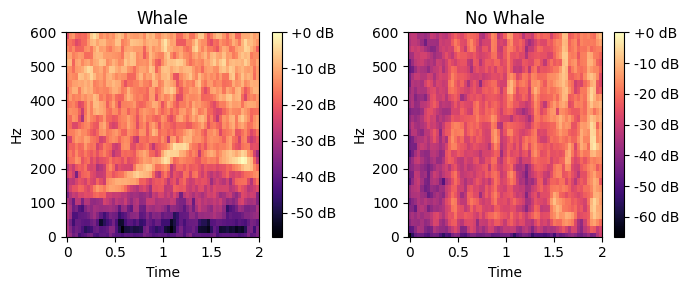

In [5]:
normalize(audio_df, 'audio')
display_random_samples(audio_df)

### Hacemos un análisis exploratorio de los datos

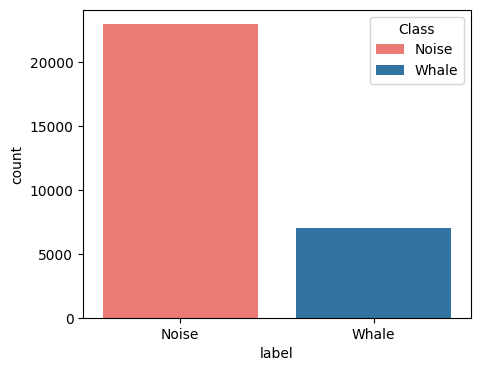

In [6]:
show_class_balance(audio_df)

In [7]:
# plot_average_spectrograms(audio_df)

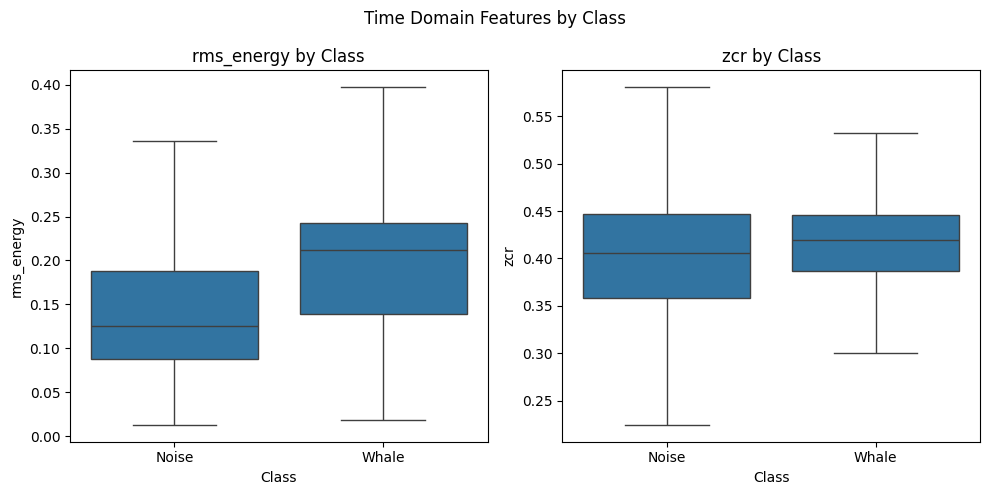

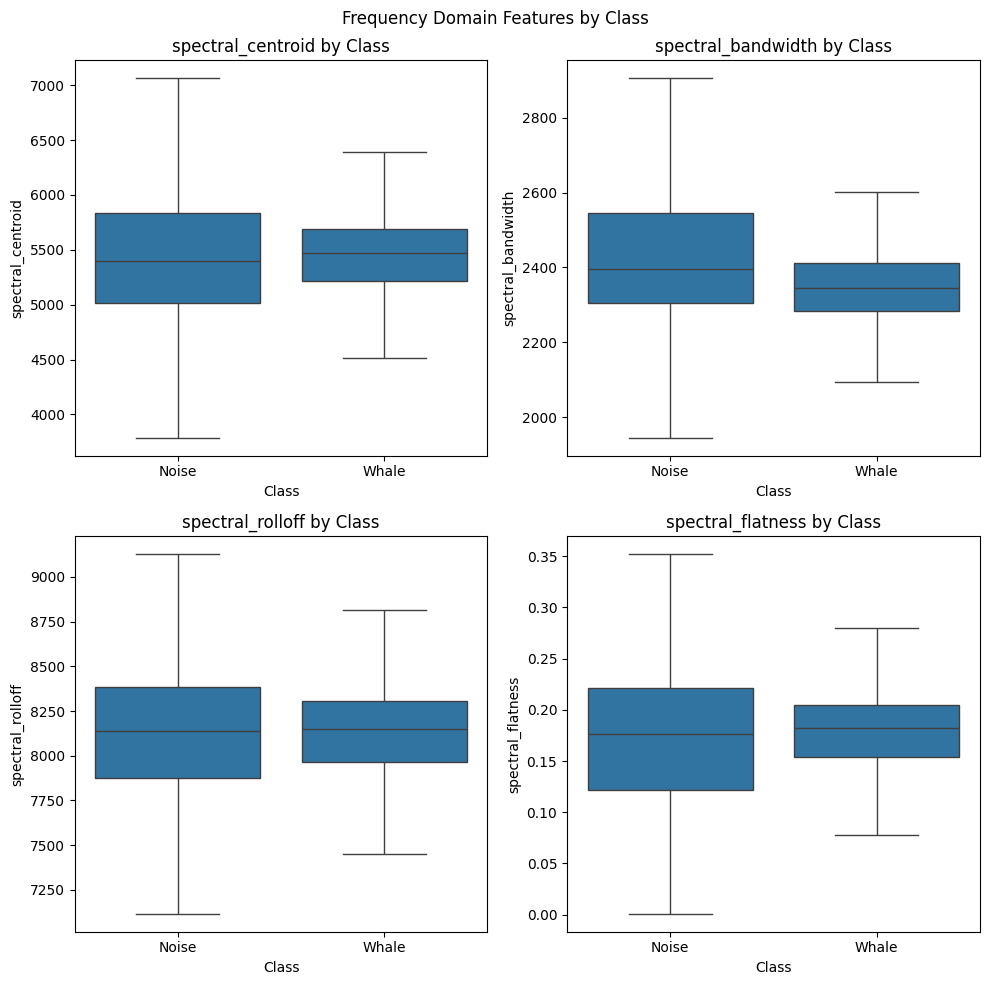

In [ ]:
audio_features_df = extract_acoustic_features(audio_df)
# display_features_boxplots(audio_features_df)

In [9]:
# EXPERIMENTO PCA
flattened_mel_spectrogram = get_all_mel_spectrograms(audio_df)
# pca = PCA(n_components=2)
# spec_pca = pca.fit_transform(flattened_mel_spectrogram)

# plot_pca(audio_df, spec_pca)

### Arrancamos el modelado

### Importamos las librerías necesarias

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, ParameterGrid, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [11]:
def normalize_spectrogram(spec, global_min, global_max):
    norm_spec = (spec - global_min) / (global_max - global_min + 1e-8)
    return norm_spec

def denormalize_spectrogram(norm_spec, min_val, max_val):
    return norm_spec * (max_val - min_val + 1e-8) + min_val

def compute_global_min_max(audio_df):
    whale_specs = [get_melspectrogram(audio) for audio, label in zip(audio_df['audio'], audio_df['label']) if label == 1]
    global_min = np.min([spec.min() for spec in whale_specs])
    global_max = np.max([spec.max() for spec in whale_specs])
    return global_min, global_max

def get_class_weights(y):
    weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    return torch.tensor(weights, dtype=torch.float32)

def get_data_loaders(train_df):
    X = get_all_mel_spectrograms(train_df)
    y = train_df['label'].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128)

    return train_loader, val_loader



### Creamos las clases y funciones necesarias para los modelos de clasificación

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[256, 128, 64], output_dim=2):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_layer in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_layer))
            layers.append(nn.ReLU())
            prev_dim = hidden_layer
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, x):
        return self.model(x)
    
    def train_model(self, train_loader, val_loader, epochs=50, lr=0.001, weight_decay=1e-5, early_stopping_patience=None):
        self.to(self.device)
        y_train = train_loader.dataset.tensors[1].cpu().numpy().flatten()
        loss_function = nn.CrossEntropyLoss(weight=get_class_weights(y_train).to(self.device))
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
            avg_train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(avg_train_loss)

            val_loss, val_acc = self.evaluate(val_loader, return_metrics=True)
            val_losses.append(val_loss)

            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

            # Early stopping
            if early_stopping_patience is not None:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        print("Early stopping triggered.")
                        break

        return train_losses, val_losses

    def evaluate(self, val_loader, return_metrics=False):
        self.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        loss_function = nn.CrossEntropyLoss()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        avg_val_loss = val_loss / len(val_loader.dataset)
        accuracy = 100 * correct / total
        if return_metrics:
            return avg_val_loss, accuracy
        print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
# ESTO DE ABAJO NO ANDA TODAVIA PERO ES PARA YA TENERLO
def MLP_cross_val(train_loader:DataLoader, val_loader:DataLoader, input_dim:int, hidden_layers:list, output_dim:int, epochs:int, lr:list, weight_decay:list, regularization_term:list, early_stopping_patience:list):
    best_model = None
    best_val_loss = float('inf')
    best_params = None
    global_min, global_max = compute_global_min_max(train_loader.dataset)
    for lr_val in lr:
        for wd in weight_decay:
            for reg in regularization_term:
                model = MLP(input_dim, hidden_layers, output_dim)
                model.train(train_loader, val_loader, epochs=epochs, lr=lr_val, weight_decay=wd)

                # Evaluate on validation set
                val_loss = 0.0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(model.device), labels.to(model.device)
                        outputs = model(inputs)
                        loss = nn.CrossEntropyLoss()(outputs, labels)
                        val_loss += loss.item()

                val_loss /= len(val_loader)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = (lr_val, wd, reg)
    print(f'Best Validation Loss: {best_val_loss:.4f} with params: LR={best_params[0]}, WD={best_params[1]}, Reg={best_params[2]}')
    return best_model, best_params    

def train_random_forest(X_train, y_train, X_val, y_val):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"Validation Accuracy (Random Forest): {acc:.4f}")
    return rf

def train_gradient_boosting(X_train, y_train, X_val, y_val):
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    gb.fit(X_train, y_train)
    preds = gb.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"Validation Accuracy (Gradient Boosting): {acc:.4f}")
    return gb



### Obtenemos los audios de entrenamiento

In [13]:
audio_train_df = audio_df[audio_df['clip_name'].str.contains('train')]

### Hacemos validación cruzada alternando entre una loss con pesos y cambiando la máxima frecuencia de los espectrogramas

explicar lo de las frecuencias de 500 (standard ballena) - y 600 imgs

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_mlp_with_maxfreqs(audio_train_df, MLP, get_all_mel_spectrograms, get_class_weights,
                                    max_freq_list=[500, 600, 1000], n_folds=5, patience=3,
                                    batch_size=128, learning_rate=1e-3, seed=42):

    original_max_freq = globals().get("MAX_FREQ", None)
    SEED = seed

    for max_frequency in max_freq_list:
        print(f'\n--- MAX_FREQ = {max_frequency} HZ ---')
        globals()["MAX_FREQ"] = max_frequency

        X = get_all_mel_spectrograms(audio_train_df)
        y = audio_train_df['label'].values

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)

        for weighted in [False, True]:
            print(f'\n--- WEIGHTED LOSS = {weighted} ---')
            fold_aucs = []
            fold_f1s = []

            for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
                print(f'\nFold {fold+1}/{n_folds}')
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
                y_train_tensor = torch.tensor(y_train, dtype=torch.long)
                X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
                y_val_tensor = torch.tensor(y_val, dtype=torch.long)

                train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

                mlp = MLP(X_train.shape[1]).to(device)
                if weighted:
                    weights = get_class_weights(y_train).to(device)
                    loss_function = nn.CrossEntropyLoss(weight=weights)
                else:
                    loss_function = nn.CrossEntropyLoss()
                optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

                best_auc = 0
                counter = 0

                for epoch in range(20):
                    mlp.train()
                    for xb, yb in train_loader:
                        xb, yb = xb.to(device), yb.to(device)
                        optimizer.zero_grad()
                        loss = loss_function(mlp(xb), yb)
                        loss.backward()
                        optimizer.step()

                    mlp.eval()
                    all_probs, all_targets = [], []
                    with torch.no_grad():
                        for xb, yb in val_loader:
                            xb = xb.to(device)
                            probs = torch.softmax(mlp(xb), dim=1)[:, 1].cpu().numpy()
                            all_probs.extend(probs)
                            all_targets.extend(yb.numpy())

                    auc = roc_auc_score(all_targets, all_probs)
                    print(f"Epoch {epoch+1} - AUC: {auc:.4f}")

                    if auc > best_auc:
                        best_auc = auc
                        counter = 0
                    else:
                        counter += 1
                        if counter >= patience:
                            print("Early stopping")
                            break

                print(f"AUC MLP final (fold {fold+1}): {best_auc:.4f}")
                y_pred = [1 if p > 0.5 else 0 for p in all_probs]
                f1 = f1_score(all_targets, y_pred)
                print(f"F1-SCORE (fold {fold+1}): {f1:.4f}")

                fold_aucs.append(best_auc)
                fold_f1s.append(f1)

            print(f'\nMean AUC over {n_folds} folds: {np.mean(fold_aucs):.4f}')
            print(f'Mean F1-Score over {n_folds} folds: {np.mean(fold_f1s):.4f}')

    if original_max_freq is not None:
        globals()["MAX_FREQ"] = original_max_freq

# train_mlp_with_maxfreqs(
#     audio_train_df=audio_train_df,
#     MLP=MLP,
#     get_all_mel_spectrograms=get_all_mel_spectrograms,
#     get_class_weights=get_class_weights,
#     max_freq_list=[500, 600, 1000],
#     n_folds=5,
#     patience=3
# )


### Preprocesamos los datos para darselos al modelo

In [15]:
X = get_all_mel_spectrograms(audio_train_df)
y = audio_train_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

### Entrenamos 3 clasificadores

### Entrenamos un MLP

In [ ]:
# mlp_torch = MLP(X_train.shape[1])
# mlp_torch.to(device)
# train_losses, val_losses = mlp_torch.train_model(train_loader, val_loader, epochs=20, lr=1e-3)

Epoch 1/20 | Train Loss: 0.6139 | Val Loss: 0.3656 | Val Acc: 83.62%
Epoch 2/20 | Train Loss: 0.3898 | Val Loss: 0.3479 | Val Acc: 84.95%
Epoch 3/20 | Train Loss: 0.3587 | Val Loss: 0.4765 | Val Acc: 79.33%
Epoch 4/20 | Train Loss: 0.3615 | Val Loss: 0.3384 | Val Acc: 84.93%
Epoch 5/20 | Train Loss: 0.3305 | Val Loss: 0.2937 | Val Acc: 86.87%
Epoch 6/20 | Train Loss: 0.3285 | Val Loss: 0.3596 | Val Acc: 83.13%
Epoch 7/20 | Train Loss: 0.3195 | Val Loss: 0.3086 | Val Acc: 85.48%
Epoch 8/20 | Train Loss: 0.3100 | Val Loss: 0.4402 | Val Acc: 80.03%
Epoch 9/20 | Train Loss: 0.3024 | Val Loss: 0.2744 | Val Acc: 86.72%
Epoch 10/20 | Train Loss: 0.3035 | Val Loss: 0.3259 | Val Acc: 84.15%
Epoch 11/20 | Train Loss: 0.2964 | Val Loss: 0.2998 | Val Acc: 86.27%
Epoch 12/20 | Train Loss: 0.2864 | Val Loss: 0.3041 | Val Acc: 85.85%
Epoch 13/20 | Train Loss: 0.3030 | Val Loss: 0.3830 | Val Acc: 81.25%
Epoch 14/20 | Train Loss: 0.2836 | Val Loss: 0.3222 | Val Acc: 85.28%
Epoch 15/20 | Train Loss: 0.2

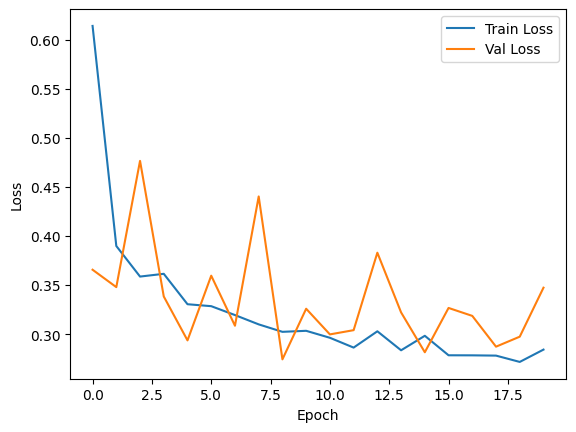

In [ ]:
def plot_learning_curves(train_losses, val_losses):
# poner esto adentro del modelo como plot_learning_curves
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# plot_learning_curves(train_losses, val_losses)

### Pasamos los tensores a numpy

In [18]:
X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()
X_val_np = X_val_tensor.numpy()
y_val_np = y_val_tensor.numpy()

### Entrenamos un Random Forest

In [19]:
# rf_model = train_random_forest(X_train_np, y_train_np, X_val_np, y_val_np)

### Entrenamos un Gradient Boosting
cambiar a xgboost

In [20]:
# gb_model = train_gradient_boosting(X_train_np, y_train_np, X_val_np, y_val_np)

### Visualizamos las curvas ROC de los modelos

In [21]:
def get_mlp_probs(model, val_loader, device):
    """Predice probabilidades de clase positiva con un MLP de PyTorch"""
    model.eval()
    probs = []
    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            outputs = model(xb)
            p = F.softmax(outputs, dim=1)[:, 1]  # clase positiva
            probs.extend(p.cpu().numpy())
    return np.array(probs)

def get_model_probs_sklearn(model, X_val):
    """Predice probabilidades de clase positiva con un modelo sklearn"""
    return model.predict_proba(X_val)[:, 1]

def compute_roc(y_true, y_probs):
    """Calcula AUC, FPR y TPR"""
    auc = roc_auc_score(y_true, y_probs)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    return auc, fpr, tpr

def plot_roc_curves(roc_data_dict):
    """
    Plotea curvas ROC.
    roc_data_dict: dict con keys = nombres de modelos, values = (auc, fpr, tpr)
    """
    plt.figure(figsize=(8, 6))
    for name, (auc, fpr, tpr) in roc_data_dict.items():
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# mlp_probs = get_mlp_probs(mlp_torch, val_loader, device)
# rf_probs = get_model_probs_sklearn(rf_model, X_val_np)
# gb_probs = get_model_probs_sklearn(gb_model, X_val_np)

# mlp_auc, fpr_mlp, tpr_mlp = compute_roc(y_val_np, mlp_probs)
# rf_auc, fpr_rf, tpr_rf = compute_roc(y_val_np, rf_probs)
# gb_auc, fpr_gb, tpr_gb = compute_roc(y_val_np, gb_probs)

# roc_data = {
#     "MLP": (mlp_auc, fpr_mlp, tpr_mlp),
#     "Random Forest": (rf_auc, fpr_rf, tpr_rf),
#     "Gradient Boosting": (gb_auc, fpr_gb, tpr_gb)
# }

# plot_roc_curves(roc_data)


### Entrenamos modelos generativos para data augmentation

#### Variational Autoencoder (VAE)

In [22]:
# VARIATIONAL AUTOENCODER MODEL

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def loss(self, x, x_hat, mu, logvar):
        recon_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div

             clip_name  label  \
0          train1.aiff      0   
1          train2.aiff      0   
2          train3.aiff      0   
3          train4.aiff      0   
4          train5.aiff      0   
...                ...    ...   
29995  train29996.aiff      0   
29996  train29997.aiff      0   
29997  train29998.aiff      0   
29998  train29999.aiff      0   
29999  train30000.aiff      0   

                                                filepath  \
0      data/whale-detection-challenge/data/train\trai...   
1      data/whale-detection-challenge/data/train\trai...   
2      data/whale-detection-challenge/data/train\trai...   
3      data/whale-detection-challenge/data/train\trai...   
4      data/whale-detection-challenge/data/train\trai...   
...                                                  ...   
29995  data/whale-detection-challenge/data/train\trai...   
29996  data/whale-detection-challenge/data/train\trai...   
29997  data/whale-detection-challenge/data/train\trai...   
299

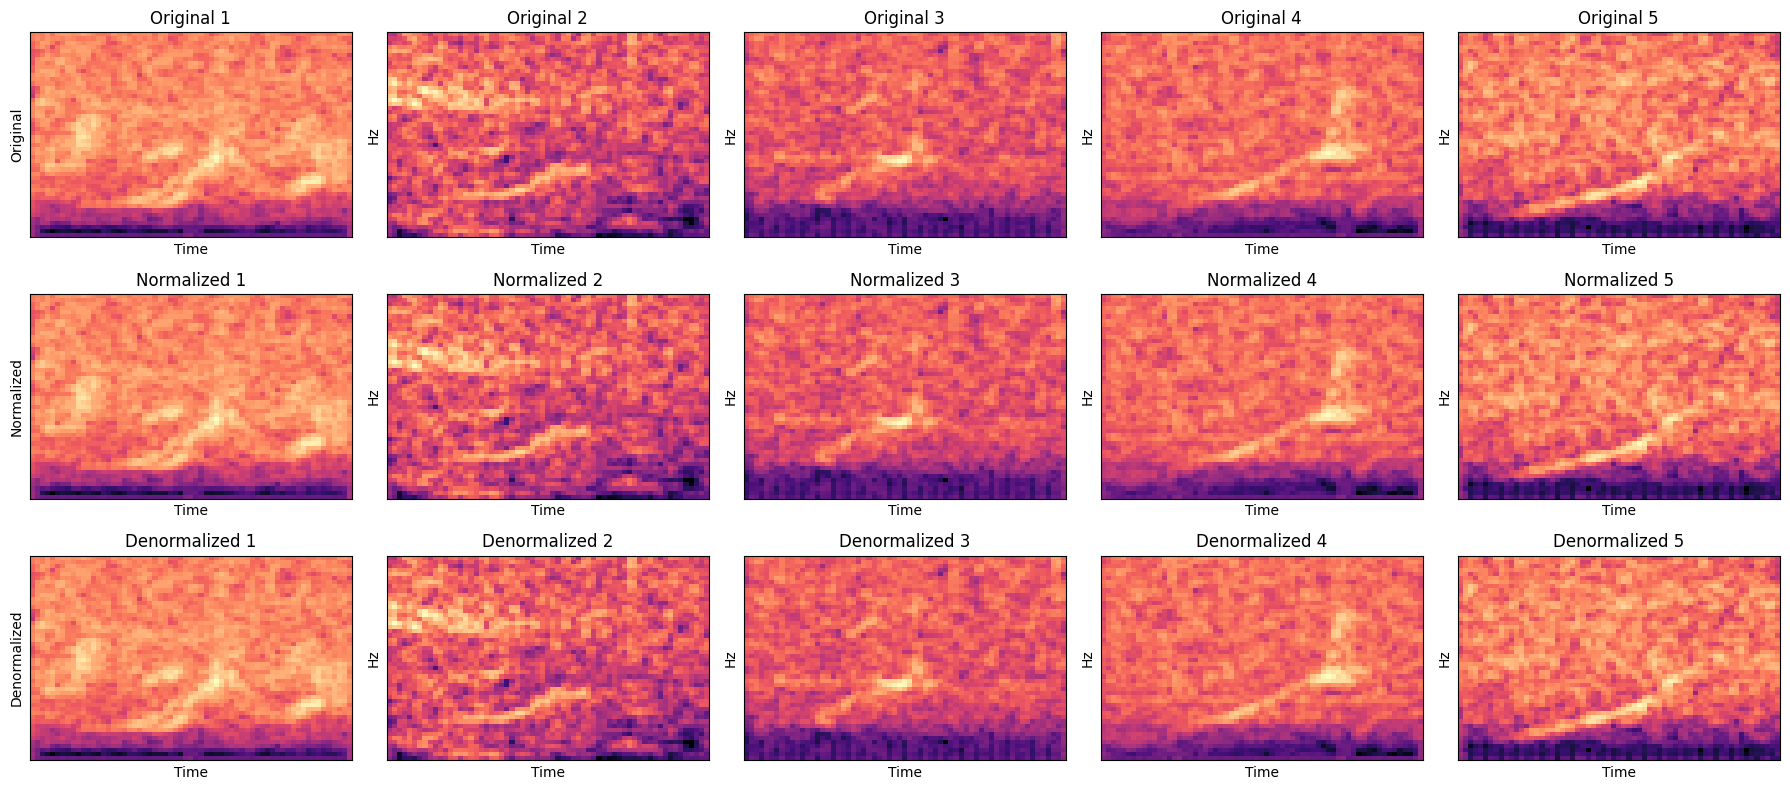

[[-33.229214 -35.363136 -46.20211  ... -38.63774  -44.521477 -44.579636]
 [-31.770988 -35.984596 -47.61613  ... -45.473064 -47.508736 -40.41755 ]
 [-34.700462 -42.51068  -47.163517 ... -44.19282  -45.98033  -42.610966]
 ...
 [-19.65347  -15.755347 -13.980202 ... -19.827393 -22.101807 -26.595238]
 [-20.521988 -16.33151  -13.673589 ... -15.751569 -22.518307 -23.939087]
 [-17.511944 -17.097256 -12.495781 ... -15.380875 -18.713755 -22.98985 ]]
[[0.58463484 0.5579608  0.4224736  ... 0.5170282  0.44348153 0.44275457]
 [0.60286266 0.55019253 0.40479836 ... 0.43158668 0.4061408  0.49478063]
 [0.56624424 0.4686165  0.41045603 ... 0.44758973 0.42524585 0.46736294]
 ...
 [0.75433165 0.80305815 0.82524747 ... 0.75215757 0.7237274  0.6675595 ]
 [0.74347514 0.7958561  0.8290801  ... 0.80310535 0.7185212  0.70076144]
 [0.7811007  0.7862843  0.84380275 ... 0.8077391  0.7660781  0.7126269 ]]
[[-33.229214 -35.363136 -46.20211  ... -38.63774  -44.521477 -44.579636]
 [-31.770988 -35.984596 -47.61613  ... 

In [ ]:
def run_experiment_preview_spectrograms():
    # EXPERIMENTO [ NO BORRAR ]

    # Preparo los espectrogramas para enchufarselos al vae
    #   - grafico 5 muestras pre y post normalizar
    print(audio_df)

    original_spec_samples = []
    normalized_samples = []
    denormalized_samples = []

    global_min, global_max = compute_global_min_max(audio_df)

    whale_audio_samples = audio_df[audio_df['label'] == 1].sample(5)['audio']

    for sample in whale_audio_samples:
        mel_spec = get_melspectrogram(sample)
        original_spec_samples.append(mel_spec)

        normalized_mel_spec = normalize_spectrogram(mel_spec, global_min, global_max)
        normalized_samples.append(normalized_mel_spec)

        denormalized_mel_spec = denormalize_spectrogram(normalized_mel_spec, global_min, global_max)
        denormalized_samples.append(denormalized_mel_spec)

    fig, axes = plt.subplots(3, 5, figsize=(18, 8))

    for i in range(5):
        # Original spectrogram
        img0 = librosa.display.specshow(original_spec_samples[i], sr=SR, hop_length=HOP_LENGTH, ax=axes[0, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        # Normalized spectrogram
        img1 = librosa.display.specshow(normalized_samples[i], sr=SR, hop_length=HOP_LENGTH, ax=axes[1, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[1, i].set_title(f'Normalized {i+1}')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

        # Denormalized spectrogram
        img2 = librosa.display.specshow(denormalized_samples[i], sr=SR, hop_length=HOP_LENGTH, ax=axes[2, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[2, i].set_title(f'Denormalized {i+1}')
        axes[2, i].set_xticks([])
        axes[2, i].set_yticks([])

    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Normalized')
    axes[2, 0].set_ylabel('Denormalized')
    plt.tight_layout()
    plt.show()

    print(original_spec_samples[-1])
    print(normalized_samples[-1])
    print(denormalized_samples[-1])

# run_experiment_preview_spectrograms()



### Obtenemos los espectrogramas de todos los audios y los normalizamos

In [25]:
global_min, global_max = compute_global_min_max(audio_df)
mel_specs = []
for whale_audio in audio_df[audio_df['label'] == 1]['audio']:
    mel = get_melspectrogram(whale_audio)
    mel_norm = normalize_spectrogram(mel, global_min, global_max)
    mel_specs.append(mel_norm.flatten())
X = np.array(mel_specs)

### Preparamos los datos para darselos al VAE

In [26]:
X = np.array(mel_specs)
X_tensor = torch.tensor(X, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_tensor), batch_size=128, shuffle=True)

### Entrenamos el VAE y generamos muestras sintéticas

In [ ]:
# TRAIN

def train_vae_model(X, train_loader, latent_dim=32, epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vae = VAE(X.shape[1], latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)

    for epoch in range(epochs):
        vae.train()
        total_loss = 0
        for xb_tuple in train_loader:  # xb_tuple is a tuple (xb,)
            xb = xb_tuple[0].to(device)
            x_hat, mu, logvar = vae(xb)
            loss = vae.loss(xb, x_hat, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)  # accumulate per sample
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return vae
# vae = train_vae_model(X, train_loader, latent_dim=32, epochs=50)

Epoch 1/50, Loss: 14.2808
Epoch 2/50, Loss: 0.0750
Epoch 3/50, Loss: 0.0618
Epoch 4/50, Loss: 0.0594
Epoch 5/50, Loss: 0.0561
Epoch 6/50, Loss: 0.0532
Epoch 7/50, Loss: 0.0518
Epoch 8/50, Loss: 0.0480
Epoch 9/50, Loss: 0.0468
Epoch 10/50, Loss: 0.0430
Epoch 11/50, Loss: 0.0411
Epoch 12/50, Loss: 0.0402
Epoch 13/50, Loss: 0.0399
Epoch 14/50, Loss: 0.0379
Epoch 15/50, Loss: 0.0367
Epoch 16/50, Loss: 0.0345
Epoch 17/50, Loss: 0.0379
Epoch 18/50, Loss: 0.0341
Epoch 19/50, Loss: 0.0305
Epoch 20/50, Loss: 0.0310
Epoch 21/50, Loss: 0.0308
Epoch 22/50, Loss: 0.0307
Epoch 23/50, Loss: 0.0266
Epoch 24/50, Loss: 0.0273
Epoch 25/50, Loss: 0.0249
Epoch 26/50, Loss: 0.0240
Epoch 27/50, Loss: 0.0317
Epoch 28/50, Loss: 0.0220
Epoch 29/50, Loss: 0.0238
Epoch 30/50, Loss: 0.0219
Epoch 31/50, Loss: 0.0234
Epoch 32/50, Loss: 0.1688
Epoch 33/50, Loss: 0.1302
Epoch 34/50, Loss: 0.0117
Epoch 35/50, Loss: 0.0112
Epoch 36/50, Loss: 0.0109
Epoch 37/50, Loss: 0.0107
Epoch 38/50, Loss: 0.0105
Epoch 39/50, Loss: 0

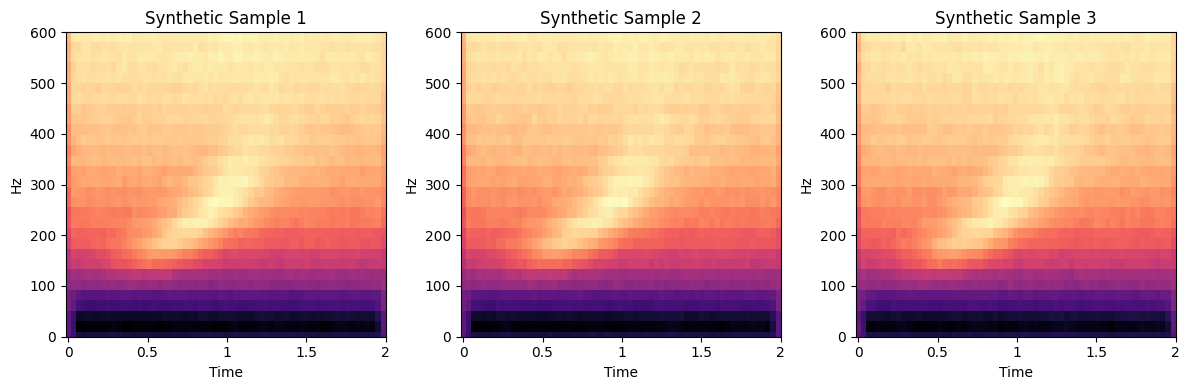

In [ ]:
def generate_synthetic_spectrograms(vae, num_samples, latent_dim, global_min, global_max):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated = vae.decode(z).cpu().numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

    for i in range(num_samples):
        spec_norm = generated[i].reshape((N_MELS, -1))
        spec = denormalize_spectrogram(spec_norm, global_min, global_max)
        librosa.display.specshow(spec, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='hz',
                                 cmap='magma', ax=axes[i], fmax=MAX_FREQ)
        axes[i].set_title(f"Synthetic Sample {i+1}")
        axes[i].set_ylim([0, MAX_FREQ])

    plt.tight_layout()
    plt.show()

    return generated
num_samples = 3
latent_dim = 32

# generated = generate_synthetic_spectrograms(vae, num_samples, latent_dim, global_min, global_max)


In [ ]:
def play_synthetic_samples(generated, global_min, global_max, num_samples):
    for i in range(num_samples):
        spec_norm = generated[i].reshape((N_MELS, -1))
        spec = denormalize_spectrogram(spec_norm, global_min, global_max)
        spec_power = librosa.db_to_power(spec)
        audio = librosa.feature.inverse.mel_to_audio(
            spec_power,
            sr=SR,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_iter=32,
            fmax=MAX_FREQ
        )
        print(f"Synthetic Sample {i+1}:")
        display(Audio(audio, rate=SR * 1.5))
# play_synthetic_samples(generated, global_min, global_max, num_samples)

Synthetic Sample 1:


Synthetic Sample 2:


Synthetic Sample 3:


### Buscamos hiperparámetros óptimos para el VAE

In [ ]:
# BÚSQUEDA DE HIPERPARÁMETROS [ CAMBIAR PARA QUE SE PUEDA PROBAR DISTINTAS ARQUITECTURAS ]

def train_vae(X, latent_dim, lr, epochs, batch_size, device):
    vae = VAE(X.shape[1], latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    vae.train()
    for epoch in range(epochs):
        for xb_tuple in loader:
            xb = xb_tuple[0].to(device)
            x_hat, mu, logvar = vae(xb)
            loss = vae.loss(xb, x_hat, mu, logvar)
            optimizer.zero_grad()
            optimizer.step()
            loss.backward()
    return vae

def evaluate_vae(vae, X, device):
    vae.eval()
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=128)
    total_loss = 0
    with torch.no_grad():
        for xb_tuple in loader:
            xb = xb_tuple[0].to(device)
            x_hat, mu, logvar = vae(xb)
            loss = vae.loss(xb, x_hat, mu, logvar)
            total_loss += loss.item() * xb.size(0)
    return total_loss / len(dataset)

def vae_hyperparameter_search(X, param_grid, device, n_splits=3, seed=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    results = []

    for params in ParameterGrid(param_grid):
        val_losses = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            vae = train_vae(X_train, **params, device=device)
            val_loss = evaluate_vae(vae, X_val, device=device)
            val_losses.append(val_loss)
        avg_loss = np.mean(val_losses)
        print(f"Params: {params}, Avg Val Loss: {avg_loss:.4f}")
        results.append((params, avg_loss))

    best_params = min(results, key=lambda x: x[1])
    print("Best params:", best_params[0])
    return best_params

param_grid = {
    'latent_dim': [8, 16, 32],
    'lr': [1e-3, 5e-4],
    'epochs': [20, 40],
    'batch_size': [64]
}

# best_params = vae_hyperparameter_search(X, param_grid, device=device, seed=SEED)

Params: {'batch_size': 64, 'epochs': 20, 'latent_dim': 8, 'lr': 0.001}, Avg Val Loss: 5.5843
Params: {'batch_size': 64, 'epochs': 20, 'latent_dim': 8, 'lr': 0.0005}, Avg Val Loss: 6.5718
Params: {'batch_size': 64, 'epochs': 20, 'latent_dim': 16, 'lr': 0.001}, Avg Val Loss: 13.1179
Params: {'batch_size': 64, 'epochs': 20, 'latent_dim': 16, 'lr': 0.0005}, Avg Val Loss: 13.4861
Params: {'batch_size': 64, 'epochs': 20, 'latent_dim': 32, 'lr': 0.001}, Avg Val Loss: 18.1376
Params: {'batch_size': 64, 'epochs': 20, 'latent_dim': 32, 'lr': 0.0005}, Avg Val Loss: 22.5478
Params: {'batch_size': 64, 'epochs': 40, 'latent_dim': 8, 'lr': 0.001}, Avg Val Loss: 6.0177
Params: {'batch_size': 64, 'epochs': 40, 'latent_dim': 8, 'lr': 0.0005}, Avg Val Loss: 8.6782
Params: {'batch_size': 64, 'epochs': 40, 'latent_dim': 16, 'lr': 0.001}, Avg Val Loss: 10.2730
Params: {'batch_size': 64, 'epochs': 40, 'latent_dim': 16, 'lr': 0.0005}, Avg Val Loss: 11.1098
Params: {'batch_size': 64, 'epochs': 40, 'latent_dim'

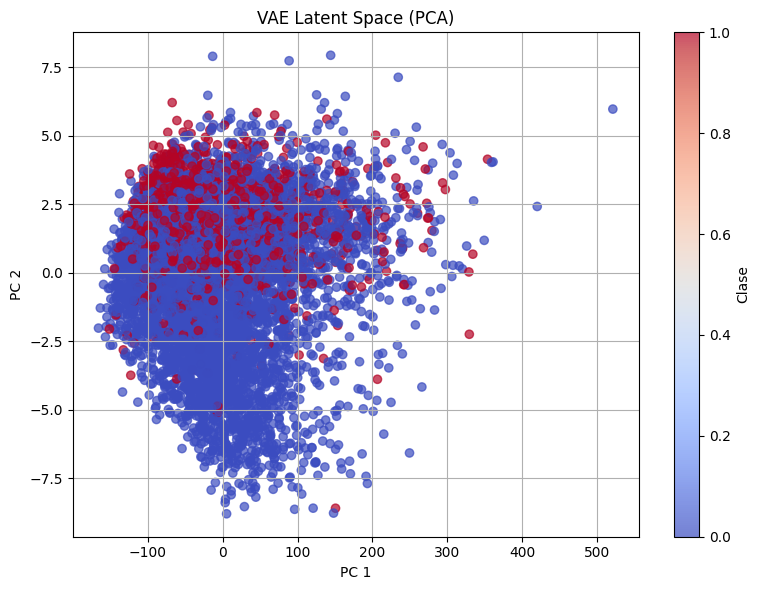

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Función para obtener las representaciones latentes
def obtener_latentes(val_loader, vae, device):
    vae.eval()
    all_mu = []
    all_labels = []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            mu, _ = vae.encode(xb)
            all_mu.append(mu.cpu().numpy())
            all_labels.append(yb.numpy())
    
    all_mu = np.concatenate(all_mu, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_mu, all_labels

# Función para aplicar PCA o t-SNE y visualizar
def visualizar_latente(val_loader, vae, device, metodo='PCA', random_state=None):
    # Obtener las representaciones latentes
    all_mu, all_labels = obtener_latentes(val_loader, vae, device)

    # Aplicar PCA o t-SNE
    if metodo == 'PCA':
        z_latente = PCA(n_components=2).fit_transform(all_mu)
        titulo = "VAE Latent Space (PCA)"
        xlabel, ylabel = "PC 1", "PC 2"
    elif metodo == 't-SNE':
        z_latente = TSNE(n_components=2, random_state=random_state).fit_transform(all_mu)
        titulo = "VAE Latent Space (t-SNE)"
        xlabel, ylabel = "t-SNE 1", "t-SNE 2"
    else:
        raise ValueError("Método debe ser 'PCA' o 't-SNE'.")

    # Graficar
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_latente[:, 0], z_latente[:, 1], c=all_labels, cmap='coolwarm', alpha=0.7)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(scatter, label="Clase")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Llamada a la función para PCA
# visualizar_latente(val_loader, vae, device, metodo='PCA')


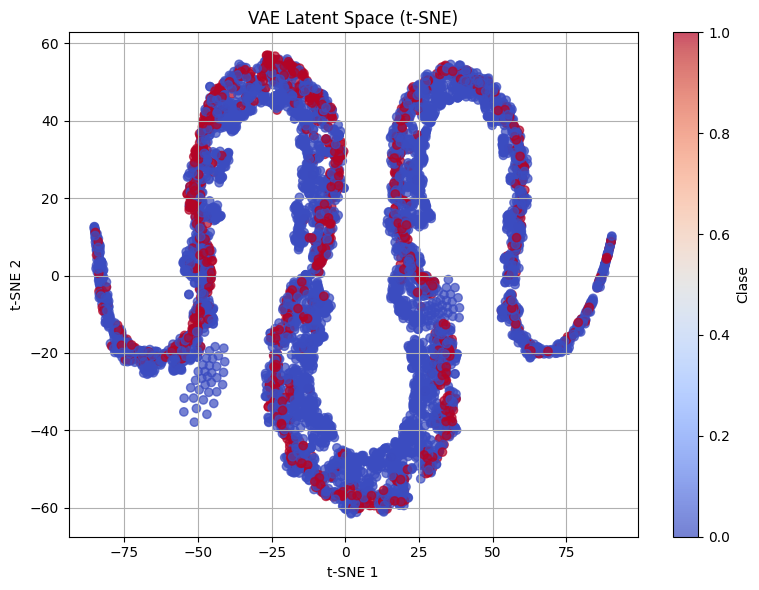

In [ ]:
# Llamada a la función para t-SNE
# visualizar_latente(val_loader, vae, device, metodo='t-SNE', random_state=SEED)

### Visualizacion de espacio latente con 2 VAEs y CVAE

In [35]:
# === ASUMIMOS ESTO HECHO ANTES (NO SE TOCA) ===
# global_min, global_max definidos
# X_tensor contiene solo espectros de ballenas (label == 1)
# train_loader = DataLoader(TensorDataset(X_tensor))

# === ARMAR DATOS COMPLETOS (ballena + no-ballena) ===
mel_specs_ballenas = []
mel_specs_no_ballenas = []

for _, row in audio_df.iterrows():
    mel = get_melspectrogram(row['audio'])
    mel_norm = normalize_spectrogram(mel, global_min, global_max)
    mel_flat = mel_norm.flatten()

    if row['label'] == 1:
        mel_specs_ballenas.append(mel_flat)
    else:
        mel_specs_no_ballenas.append(mel_flat)

X_ballenas = np.array(mel_specs_ballenas)
X_noballenas = np.array(mel_specs_no_ballenas)

X_total = np.vstack([X_ballenas, X_noballenas])
y_total = np.array([1]*len(X_ballenas) + [0]*len(X_noballenas))

# Tensores para PyTorch
X_tensor_total = torch.tensor(X_total, dtype=torch.float32)
y_tensor_total = torch.tensor(y_total, dtype=torch.float32).reshape(-1, 1)

# === DATALOADERS ===
train_loader_ballenas = DataLoader(TensorDataset(torch.tensor(X_ballenas, dtype=torch.float32)), batch_size=128, shuffle=True)
train_loader_total = DataLoader(TensorDataset(X_tensor_total, y_tensor_total), batch_size=128, shuffle=True)

In [ ]:
import copy
# === DEFINICIÓN CVAE ===
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=32, cond_dim=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x, y):
        x_in = torch.cat([x, y], dim=1)
        h = self.encoder(x_in)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def decode(self, z, y):
        z_in = torch.cat([z, y], dim=1)
        return self.decoder(z_in)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, y)
        return x_hat, mu, logvar

    def loss(self, x, x_hat, mu, logvar):
        recon = nn.functional.mse_loss(x_hat, x, reduction='mean')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon + kl

# === ENTRENAR CVAE con early stopping ===
def train_cvae(cvae, train_loader, patience=5, max_epochs=50):
    optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model = None

    for epoch in range(max_epochs):
        cvae.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            x_hat, mu, logvar = cvae(xb, yb)
            loss = cvae.loss(xb, x_hat, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"[CVAE] Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = copy.deepcopy(cvae.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"[CVAE] Early stopping at epoch {epoch+1}")
                break

    cvae.load_state_dict(best_model)

# === ENTRENAR VAEs SEPARADOS con early stopping ===
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def loss(self, x, x_hat, mu, logvar):
        recon = nn.functional.mse_loss(x_hat, x, reduction='mean')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon + kl

def train_vae(vae, X_data, name, patience=5, max_epochs=50):
    loader = DataLoader(TensorDataset(torch.tensor(X_data, dtype=torch.float32)), batch_size=128, shuffle=True)
    opt = optim.Adam(vae.parameters(), lr=1e-3)
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model = None

    for epoch in range(max_epochs):
        vae.train()
        total_loss = 0
        for (xb,) in loader:
            xb = xb.to(device)
            x_hat, mu, logvar = vae(xb)
            loss = vae.loss(xb, x_hat, mu, logvar)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)

        avg_loss = total_loss / len(loader.dataset)
        print(f"[VAE {name}] Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = copy.deepcopy(vae.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"[VAE {name}] Early stopping at epoch {epoch+1}")
                break

    vae.load_state_dict(best_model)

# === Ejecución ===
cvae = CVAE(X_total.shape[1], latent_dim=32).to(device)
train_cvae(cvae, train_loader_total)

vae_ballena = VAE(X_ballenas.shape[1], latent_dim=32).to(device)
vae_noballena = VAE(X_noballenas.shape[1], latent_dim=32).to(device)

# train_vae(vae_ballena, X_ballenas, "ballena")
# train_vae(vae_noballena, X_noballenas, "no-ballena")


[CVAE] Epoch 1, Loss: 2.2115
[CVAE] Epoch 2, Loss: 0.0455
[CVAE] Epoch 3, Loss: 0.0370
[CVAE] Epoch 4, Loss: 0.0295
[CVAE] Epoch 5, Loss: 0.0254
[CVAE] Epoch 6, Loss: 0.0219
[CVAE] Epoch 7, Loss: 0.0206
[CVAE] Epoch 8, Loss: 0.0177
[CVAE] Epoch 9, Loss: 0.0177
[CVAE] Epoch 10, Loss: 0.0163
[CVAE] Epoch 11, Loss: 0.0156
[CVAE] Epoch 12, Loss: 0.0149
[CVAE] Epoch 13, Loss: 0.0147
[CVAE] Epoch 14, Loss: 0.0528
[CVAE] Epoch 15, Loss: 0.0115
[CVAE] Epoch 16, Loss: 0.0114
[CVAE] Epoch 17, Loss: 0.0114
[CVAE] Epoch 18, Loss: 0.0114
[CVAE] Epoch 19, Loss: 0.0114
[CVAE] Epoch 20, Loss: 0.0114
[CVAE] Epoch 21, Loss: 0.0114
[CVAE] Epoch 22, Loss: 0.0114
[CVAE] Epoch 23, Loss: 0.0114
[CVAE] Epoch 24, Loss: 0.0114
[CVAE] Epoch 25, Loss: 0.0114
[CVAE] Epoch 26, Loss: 0.0114
[CVAE] Epoch 27, Loss: 0.0114
[CVAE] Epoch 28, Loss: 0.0114
[CVAE] Epoch 29, Loss: 0.0114
[CVAE] Epoch 30, Loss: 0.0114
[CVAE] Early stopping at epoch 30
[VAE ballena] Epoch 1, Loss: 9.0340
[VAE ballena] Epoch 2, Loss: 0.0626
[VA

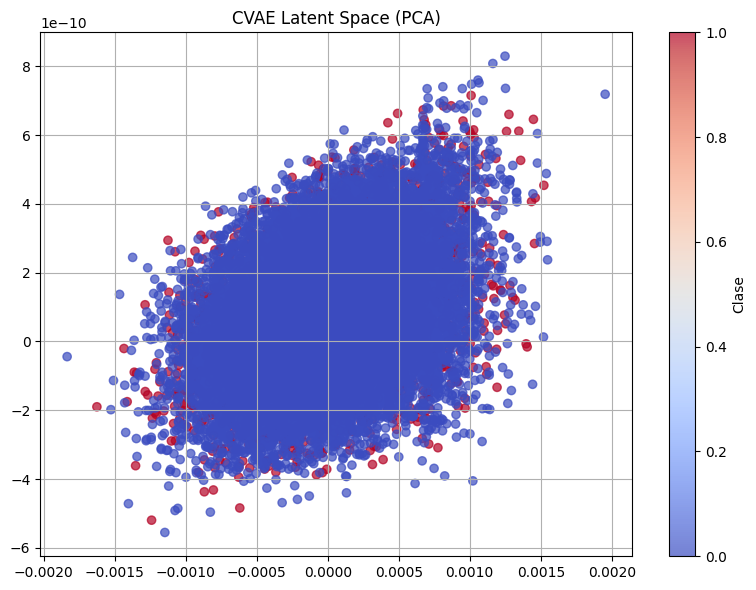

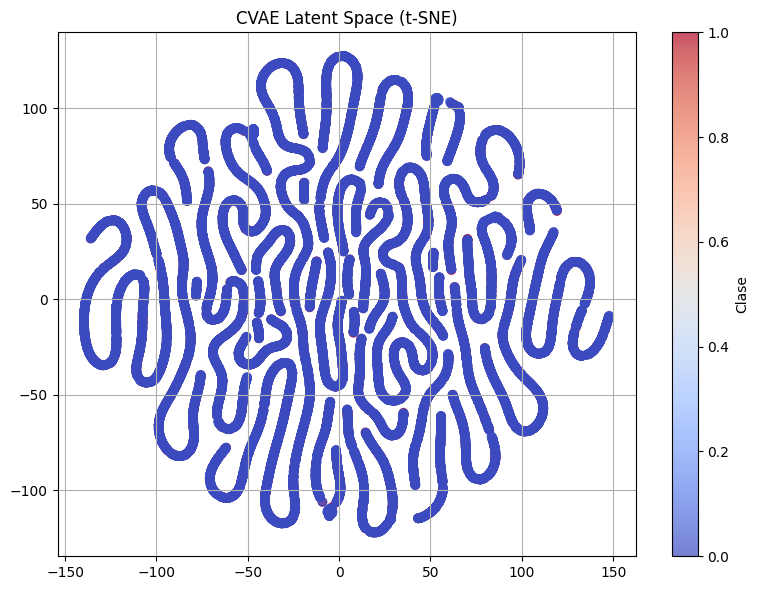

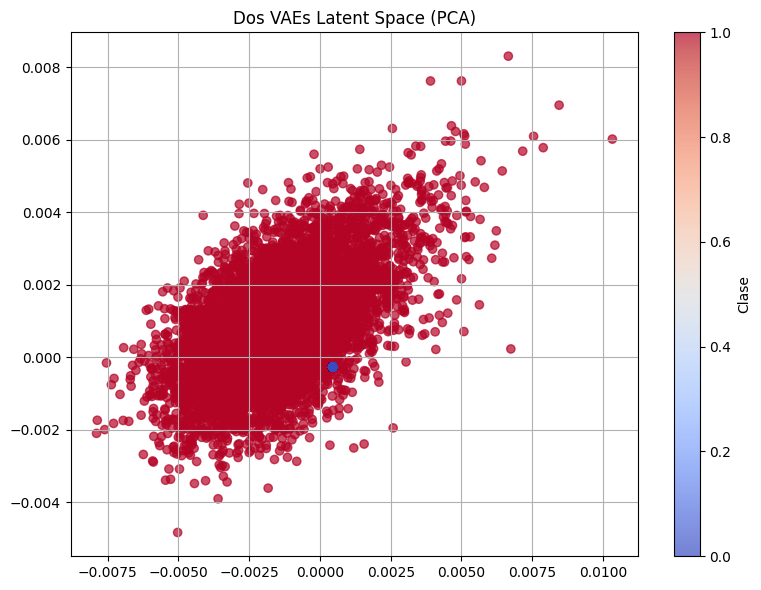

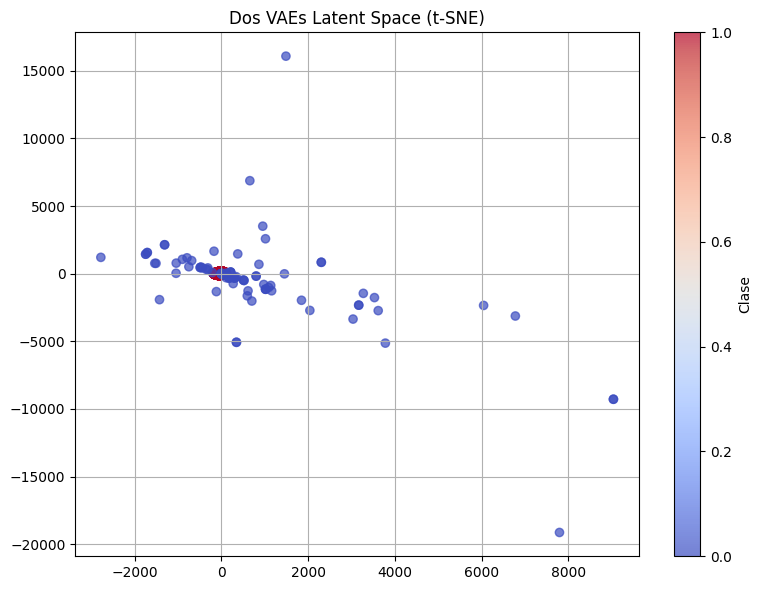

In [40]:
# === REPRESENTACIONES LATENTES ===
def get_latents(vae, X):
    vae.eval()
    mus = []
    loader = DataLoader(torch.tensor(X, dtype=torch.float32), batch_size=128)
    with torch.no_grad():
        for xb in loader:
            xb = xb.to(device)
            mu, _ = vae.encode(xb)
            mus.append(mu.cpu().numpy())
    return np.vstack(mus)

with torch.no_grad():
    mu_cvae, _ = cvae.encode(X_tensor_total.to(device), y_tensor_total.to(device))
mu_cvae = mu_cvae.cpu().numpy()

mu_ballena = get_latents(vae_ballena, X_ballenas)
mu_noballena = get_latents(vae_noballena, X_noballenas)
mu_2vae = np.vstack([mu_ballena, mu_noballena])
y_2vae = np.array([1]*len(mu_ballena) + [0]*len(mu_noballena))

# === VISUALIZACIÓN ===
def plot_latente(z, y, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z[:, 0], z[:, 1], c=y, cmap='coolwarm', alpha=0.7)
    plt.colorbar(scatter, label="Clase")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# z_cvae_pca = PCA(2).fit_transform(mu_cvae)
# z_cvae_tsne = TSNE(2, random_state=42).fit_transform(mu_cvae)
# plot_latente(z_cvae_pca, y_total, "CVAE Latent Space (PCA)")
# plot_latente(z_cvae_tsne, y_total, "CVAE Latent Space (t-SNE)")

# z_2vae_pca = PCA(2).fit_transform(mu_2vae)
# z_2vae_tsne = TSNE(2, random_state=42).fit_transform(mu_2vae)
# plot_latente(z_2vae_pca, y_2vae, "Dos VAEs Latent Space (PCA)")
# plot_latente(z_2vae_tsne, y_2vae, "Dos VAEs Latent Space (t-SNE)")


### Entrenamos un Generative Adversarial Network (GAN)

In [ ]:
# --- GAN Models ---

class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)  # Sin Sigmoid por defecto
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1)  # Sin Sigmoid
        )

    def forward(self, x):
        return self.model(x)

# --- GAN Training Loop ---

def train_gan(train_loader, input_dim, latent_dim=32, epochs=100, save_every=10, sample_dir="gan_samples"):
    os.makedirs(sample_dir, exist_ok=True)

    generator = Generator(latent_dim, input_dim).to(device)
    discriminator = Discriminator(input_dim).to(device)

    criterion = nn.BCEWithLogitsLoss()
    g_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

    best_loss = float('inf')
    early_stop_counter = 0
    patience = 10  # Número de épocas para el early stopping

    for epoch in range(epochs):
        g_loss_epoch, d_loss_epoch = 0.0, 0.0

        for xb_tuple in train_loader:
            real_data = xb_tuple[0].to(device)
            batch_size = real_data.size(0)

            # --- Train Discriminator ---
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_data = generator(z)

            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            d_real = discriminator(real_data)
            d_fake = discriminator(fake_data.detach())

            d_loss = criterion(d_real, real_labels) + criterion(d_fake, fake_labels)
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --- Train Generator ---
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_data = generator(z)
            g_loss = criterion(discriminator(fake_data), real_labels)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()

        d_loss_epoch /= len(train_loader)
        g_loss_epoch /= len(train_loader)
        print(f"[GAN] Epoch {epoch+1} | D Loss: {d_loss_epoch:.4f} | G Loss: {g_loss_epoch:.4f}")

        # --- Early Stopping ---
        if g_loss_epoch < best_loss:
            best_loss = g_loss_epoch
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

        # --- Save generated samples ---
        if (epoch + 1) % save_every == 0 or epoch == 0:
            generator.eval()
            with torch.no_grad():
                z = torch.randn(3, latent_dim, device=device)
                samples = generator(z).cpu().numpy()

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            for i in range(3):
                spec_norm = samples[i].reshape((N_MELS, -1))
                spec = denormalize_spectrogram(spec_norm, global_min, global_max)
                librosa.display.specshow(
                    spec, sr=SR, hop_length=HOP_LENGTH,
                    x_axis='time', y_axis='hz', cmap='magma',
                    ax=axes[i], fmax=MAX_FREQ
                )
                axes[i].set_title(f"Sample {i+1} (Epoch {epoch+1})")
                axes[i].set_ylim([0, MAX_FREQ])
            plt.tight_layout()
            plt.savefig(f"{sample_dir}/epoch_{epoch+1}.png")
            plt.close()
            generator.train()
    return generator

input_dim = X_tensor.shape[1]
# generator = train_gan(train_loader, input_dim=input_dim, latent_dim=32, epochs=100)

[GAN] Epoch 1 | D Loss: 0.3706 | G Loss: 1.7452
[GAN] Epoch 2 | D Loss: 0.2244 | G Loss: 2.3691
[GAN] Epoch 3 | D Loss: 0.0425 | G Loss: 4.0683
[GAN] Epoch 4 | D Loss: 0.0112 | G Loss: 5.1159
[GAN] Epoch 5 | D Loss: 0.1189 | G Loss: 5.5996
[GAN] Epoch 6 | D Loss: 0.7392 | G Loss: 1.0413
[GAN] Epoch 7 | D Loss: 0.6190 | G Loss: 1.1201
[GAN] Epoch 8 | D Loss: 0.2678 | G Loss: 2.2342
[GAN] Epoch 9 | D Loss: 0.1868 | G Loss: 3.4185
[GAN] Epoch 10 | D Loss: 1.0775 | G Loss: 1.5045
[GAN] Epoch 11 | D Loss: 0.5227 | G Loss: 1.1816
[GAN] Epoch 12 | D Loss: 0.5834 | G Loss: 1.1877
[GAN] Epoch 13 | D Loss: 0.6932 | G Loss: 1.2100
[GAN] Epoch 14 | D Loss: 0.9583 | G Loss: 1.0032
[GAN] Epoch 15 | D Loss: 1.0668 | G Loss: 0.9305
[GAN] Epoch 16 | D Loss: 0.9725 | G Loss: 0.9784
[GAN] Epoch 17 | D Loss: 1.1375 | G Loss: 0.8794
[GAN] Epoch 18 | D Loss: 1.3040 | G Loss: 0.7633
[GAN] Epoch 19 | D Loss: 1.2740 | G Loss: 0.8158
[GAN] Epoch 20 | D Loss: 1.3398 | G Loss: 0.7910
[GAN] Epoch 21 | D Loss: 1.37

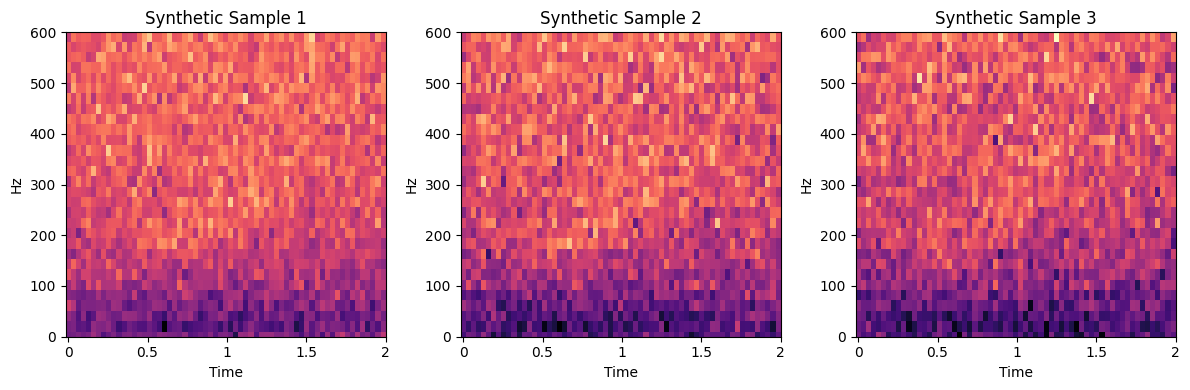

In [ ]:
def generate_synthetic_spectrograms_gan(generator, num_samples, latent_dim, global_min, global_max):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim, device=device)
        generated = generator(z).cpu().numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

    for i in range(num_samples):
        spec_norm = generated[i].reshape((N_MELS, -1))
        spec = denormalize_spectrogram(spec_norm, global_min, global_max)
        librosa.display.specshow(spec, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='hz',
                                 cmap='magma', ax=axes[i], fmax=MAX_FREQ)
        axes[i].set_title(f"Synthetic Sample {i+1}")
        axes[i].set_ylim([0, MAX_FREQ])

    plt.tight_layout()
    plt.show()

    return generated

# Parámetros
latent_dim = 32
num_samples = 3

# Generación de espectrogramas sintéticos
# generated_spectrograms = generate_synthetic_spectrograms_gan(
#     generator=generator,
#     num_samples=num_samples,
#     latent_dim=latent_dim,
#     global_min=global_min,
#     global_max=global_max
# )
